# Back Propagation with TensorFlow

## Setup
First, we need to load TensorFlow and setup the basic parts of the graph - inputs `(a_0, y)`, and states `(w_1, b_1, w_2, b_2)`.

In [ ]:
import tensorflow
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

a_0 = tf.placeholder(tf.float32, [None, 784])
y = tf.placeholder(tf.float32, [None, 10])

middle = 30
w_1 = tf.Variable(tf.truncated_normal([784, middle]))
b_1 = tf.Variable(tf.truncated_normal([1, middle]))
w_2 = tf.Variable(tf.truncated_normal([middle, 10]))
b_2 = tf.Variable(tf.truncated_normal([1, 10]))

## The sigmoid function
Our sigmoid function, although provided by TensorFlow extensive function library, is brought here as reference:

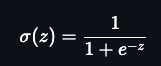

In [ ]:
def sigma(x):
    return tf.div(tf.constant(1.0), tf.add(tf.constant(1.0), tf.exp(tf.negative(x))))

## The forward propagation

Provided that the input image is given by the a_0 a matrix, calculating forward propagation for multiple images at a time can be done with simple matrix multiplication, defined as such:

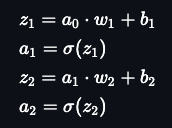	
 
Given a tensor of multiple images, this can done in TensorFlow for all them at the same time (thanks to 'broadcasting'), so the above gets a one-to-one translation in TensorFlow:

In [ ]:
z_1 = tf.add(tf.matmul(a_0, w_1), b_1)
a_1 = sigma(z_1)
z_2 = tf.add(tf.matmul(a_1, w_2), b_2)
a_2 = sigma(z_2)

## Difference

The input provides yy as the test for the accuracy of the network's output, so we compute the following vector:

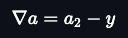

In [ ]:
diff = tf.subtract(a_2, y)

## The sigmoid prime function

Here's the derivate of the sigmoid function from above, which will be needed during the backward propagation:

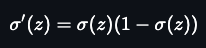

In [ ]:
def sigmaprime(x):
    return tf.multiply(sigma(x), tf.subtract(tf.constant(1.0), sigma(x)))

## Backward propagation

The most complicated part is the backward propagation. First, we need to compute the deltas of the weights and biases. In the original book the Python code was a bit puzzling, but here we can describe the same algorithm in a functional, stateless way.

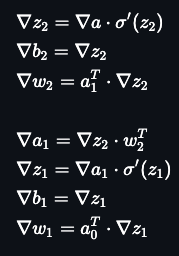

In [ ]:
d_z_2 = tf.multiply(diff, sigmaprime(z_2))
d_b_2 = d_z_2
d_w_2 = tf.matmul(tf.transpose(a_1), d_z_2)

d_a_1 = tf.matmul(d_z_2, tf.transpose(w_2))
d_z_1 = tf.multiply(d_a_1, sigmaprime(z_1))
d_b_1 = d_z_1
d_w_1 = tf.matmul(tf.transpose(a_0), d_z_1)

## Updating the network

We take the computed \nabla∇ and update the weights in one step. Note that the following does not precisely match the book - I have omitted the constant 1/n1/n divider. For simplicity, it's not really needed, as it comes into play inside the \etaη itself, in this case.

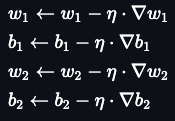

In TensorFlow, it can translate to a list of a assignments:


In [ ]:
eta = tf.constant(0.5)
step = [
    tf.assign(w_1, tf.subtract(w_1, tf.multiply(eta, d_w_1))),
    tf.assign(b_1, tf.subtract(b_1, tf.multiply(eta, tf.reduce_mean(d_b_1, axis=[0])))),
    tf.assign(w_2, tf.subtract(w_2, tf.multiply(eta, d_w_2))),
    tf.assign(b_2, tf.subtract(b_2, tf.multiply(eta, tf.reduce_mean(d_b_2, axis=[0])))),
]

## Running and testing the training process

The following will be able to train the network and test it in the meanwhile, using mini-batches of 10. Here, I chose to test with 1000 items from the test set, every 1000 mini-batches.

In [ ]:
acct_mat = tf.equal(tf.argmax(a_2, 1), tf.argmax(y, 1))
acct_res = tf.reduce_sum(tf.cast(acct_mat, tf.float32))

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

for i in range(10000):
    batch_xs, batch_ys = mnist.train.next_batch(10)
    sess.run(step, feed_dict={a_0: batch_xs, y: batch_ys})
    if i % 1000 == 0:
        res = sess.run(
            acct_res,
            feed_dict={a_0: mnist.test.images[:1000], y: mnist.test.labels[:1000]},
        )
        print(res)

### Automatic differentiation

The great part about TensorFlow is its ability to derive the step function on its own. So, instead of the rather complicated 'Backward propagation' and 'Updating the network' given above for educational purposes (see: backward propagation and updating), we can simply write the following step function alternative:

In [ ]:
cost = tf.multiply(diff, diff)
step = tf.train.GradientDescentOptimizer(0.1).minimize(cost)